In [3]:
# import tensorflow as tf
from google.colab import drive
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D
from keras.layers import TimeDistributed, LSTM, GRU, Dense, Dropout, Flatten, Reshape
from keras.models import Sequential, load_model
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils import to_categorical
from keras.backend import set_value
# from keras.backend.tensorflow_backend import set_session
# from keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping
from glob import glob
from random import shuffle, sample
from cv2 import imread, resize, imshow, waitKey, VideoCapture, destroyAllWindows
import numpy as np
from collections import defaultdict
from time import sleep
from tensorflow.compat.v1 import ConfigProto, Session
from tensorflow.compat.v1.keras.backend import set_session
from pickle import dump, load
from os import system
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from sys import exit
# f = open("loss.bin", "rb")
# losses = load(f)
# f.close()
# plt.plot(losses)
# plt.ylabel("loss")
# plt.xlabel("iteration")
# plt.show()
# exit()

modelName = "mobilenet_freezed_rmsprop_0.00001_dropout0.1_500"
absPath = "/content/drive/My Drive/TA/TA/"

drive.mount('/content/drive')
config = ConfigProto()
config.gpu_options.allow_growth = True
set_session(Session(config=config))
e = 17
model = load_model(absPath+modelName+"/ep_17.h5")
# model = Sequential()
# cnn = MobileNetV2(include_top=False, weights='imagenet') # InceptionV3(include_top=False, weights='imagenet')
# model.add(TimeDistributed(cnn, input_shape = (None, 224, 224,3), batch_size=1))
# model.add(TimeDistributed(Dropout(0.1)))
# model.add(TimeDistributed(Flatten()))
# model.add(GRU(500, activation='relu', return_sequences=True, stateful=True))
# model.add(Dropout(0.1))
# model.add(GRU(500, activation='relu', stateful=True))
# model.add(Dropout(0.1))
# model.add(Dense(11, activation='softmax'))
# for layer in model.layers:
#     layer.trainable = True
model.layers[0].trainable = False
opt =  RMSprop(lr=0.00001) # SGD(lr=0.0001, momentum=0.9) # Adam(lr=0.00001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
epoch = 0
# print(model.summary())
# exit()

classNames = ["basketball", "biking", "diving", "golf_swing", "horse_riding", "soccer_juggling", "swing", "tennis_swing", "trampoline_jumping", "volleyball_spiking", "walking"]
num = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
numCLass = len(classNames)
X = []
Y = []
trainX = []
trainY = []
valX = []
valY = []
testX = []
testY = []
a = 0
for i in range(len(classNames)):
    paths = glob(absPath+"dataset/"+classNames[i]+"/*")
    X += paths
    l = len(paths)
    Y += [i] * l
    num[i] = set(range(a, a+l))
    a += l

# numTestVal = []
# for n in num:
#     numTestVal.append(int(len(n)*0.2))
# Y = to_categorical(Y)
# X = np.array(X)
# Y = np.array(Y)

# r = []
# for i in range(len(classNames)):
#     rtemp = sample(num[i], numTestVal[i])
#     num[i] -= set(rtemp)
#     r += rtemp
# testX = X[r]
# testY = Y[r]
# f = open(absPath+modelName+"/test_data.bin", "wb")
# dump([testX, testY], f)
# f.close()

# r = []
# for i in range(len(classNames)):
#     rtemp = sample(num[i], numTestVal[i])
#     num[i] -= set(rtemp)
#     r += rtemp
# valX = X[r]
# valY = Y[r]
# f = open(absPath+modelName+"/val_data.bin", "wb")
# dump([valX,valY], f)
# f.close()

# r = []
# for i in range(len(classNames)):
#     r += num[i]
# trainX = X[r]
# trainY = Y[r]
# f = open(absPath+modelName+"/train_data.bin", "wb")
# dump([trainX, trainY], f)
# f.close()

f = open(absPath+modelName+"/test_data.bin", "rb")
testX, testY = load(f)
f.close()
f = open(absPath+modelName+"/val_data.bin", "rb")
valX, valY = load(f)
f.close()
f = open(absPath+modelName+"/train_data.bin", "rb")
trainX, trainY = load(f)
f.close()
# print(len(testX), len(valX), len(trainX), len(set(list(testX)+list(valX)+list(trainX))))
# exit()
trainLosses = []
trainAcc = []
valLosses = []
valAcc = []
confusionMatrices = [] # first index real

def run(X, Y, _model, train=False):
    cap = VideoCapture(X)
    frameIndex = 0
    j = 0
    frames = []
    while True:
        ret, frame = cap.read()
        if ret is False: break
        if frameIndex % 6 == 0: frames.append(resize(frame/255, (224, 224)))
        frameIndex += 1
    frames = np.array(frames)
    l = len(frames)
    start = timer()
    while j<l-1:
        x = np.reshape(frames[j], (1, 1, frames[j].shape[0], frames[j].shape[1], frames[j].shape[2]))
        _model.predict_on_batch(x)
        j+=1
    x = np.reshape(frames[j], (1, 1, frames[j].shape[0], frames[j].shape[1], frames[j].shape[2]))
    y = np.reshape(Y, (1, Y.shape[0]))
    if train: ret = _model.train_on_batch(x=x, y=y)
    else: ret = _model.test_on_batch(x=x, y=y), np.argmax(_model.predict_on_batch(x))
    _model.reset_states()
    if train is not None: return ret
    return ret, len(frames)*6/(timer()-start)

def metrics(cm):
    precision = []
    recall = []
    f1score = []
    for i in range(len(cm)):
        precision.append(cm[i, i]/np.sum(cm[:, i]))
        recall.append(cm[i, i]/np.sum(cm[i, :]))
        f1score.append(2*precision[-1]*recall[-1]/(precision[-1]+recall[-1]))
    return np.mean(f1score), np.mean(precision), np.mean(recall)
maxAcc = 0
lastTrainLoss = 0

if e>0:
    f = open(absPath+modelName+"/loss_train.bin", "rb")
    trainLosses = load(f)
    f.close()
    f = open(absPath+modelName+"/loss_val.bin", "rb")
    valLosses = load(f)
    f.close()
    f = open(absPath+modelName+"/accuracy_val.bin", "rb")
    valAcc = load(f)
    f.close()
    f = open(absPath+modelName+"/confusion_matrices_val.bin", "rb")
    confusionMatrices = load(f)
    f.close()

while e<epoch:
    trainX = np.array(trainX)
    trainY = np.array(trainY)
    valX = np.array(valX)
    valY = np.array(valY)
    r = np.array(sample(range(len(trainX)), len(trainX)))
    trainX = trainX[r]
    trainY = trainY[r]
    r = np.array(sample(range(len(valX)), len(valX)))
    valX = valX[r]
    valY = valY[r]
    i = 0
    l = len(trainX)
    while i<l:
        ret = run(trainX[i], trainY[i], model, True)
        # print(ret)
        trainLosses.append(ret[0])
        trainAcc.append(ret[1])
        i+=1
    f = open(absPath+modelName+"/loss_train.bin", "wb")
    dump(trainLosses, f)
    f.close()
    f = open(absPath+modelName+"/accuracy_train.bin", "wb")
    dump(trainAcc, f)
    f.close()
    i = 0
    l = len(valX)
    confusionMatrices.append(np.zeros((numCLass, numCLass), dtype=np.int32))
    while i<l:
        ret = run(valX[i], valY[i], model, False)
        valLosses.append(ret[0][0])
        valAcc.append(ret[0][1])
        # print(np.argmax(valY[i]), ret[1])
        confusionMatrices[e][np.argmax(valY[i]), ret[1]] += 1
        i+=1
    f = open(absPath+modelName+"/loss_val.bin", "wb")
    dump(valLosses, f)
    f.close()
    f = open(absPath+modelName+"/accuracy_val.bin", "wb")
    dump(valAcc, f)
    f.close()
    f = open(absPath+modelName+"/confusion_matrices_val.bin", "wb")
    dump(confusionMatrices, f)
    f.close()
    print("epoch:", e)
    e += 1
    print("trainLoss:", np.mean(trainLosses[-968:]))
    print("valLoss:", np.mean(valLosses[-316:]))
    valAccTemp = np.sum(valAcc[-316:])/316.0
    if valAccTemp > maxAcc:
        maxAcc = valAccTemp
    model.save(absPath+modelName+"/ep_{}.h5".format(e))
    print("valAcc:", valAccTemp, "maxAcc:", maxAcc, "\n")

epoch = 0
# testing
if epoch<1:
    l = len(testX)
    i = 0
    confusionMatrixTest = np.zeros((numCLass, numCLass), dtype=np.int32)
    testAcc = []
    testLoss = []
    pred = []
    label = []
    fpses = []
    print("testing")
    asd = 0
    while i<l:
        ret, fps = run(testX[i], testY[i], model, None)
        fpses.append(fps)
        testLoss.append(ret[0][0])
        pred.append(ret[1])
        label.append(np.argmax(valY[i]))
        asd += ret[0][1]
        i+=1
    print("real acc", asd/l)
    f = open(absPath+modelName+"/test_pred.bin", "wb")
    dump(pred, f)
    f.close()
    f = open(absPath+modelName+"/test_label.bin", "wb")
    dump(label, f)
    f.close()
    f = open(absPath+modelName+"/test_loss.bin", "wb")
    dump(testLoss, f)
    f.close()

    f = open(absPath+modelName+"/test_pred.bin", "rb")
    pred = load(f)
    f.close()
    f = open(absPath+modelName+"/test_label.bin", "rb")
    label = load(f)
    f.close()
    f = open(absPath+modelName+"/test_loss.bin", "rb")
    testLoss = load(f)
    f.close()

    for i in range(len(pred)):
        confusionMatrixTest[label[i]][pred[i]] += 1
        if label[i] == pred[i]: testAcc.append(1)
    macrof1, precision, recall = metrics(confusionMatrixTest)
    print(confusionMatrixTest)
    print("loss:", np.mean(testLoss))
    print("acc:", np.sum(testAcc)/len(testX))
    print("macrof1:", macrof1)
    print("precision:", precision)
    print("recall:", recall)
    print(np.mean(fps))

# print(videoLength)
# video shape :  num video
# (240, 320) :  1330
# (262, 320) :  24
# (238, 320) :  8
# (214, 320) :  8
# (239, 320) :  16
# (182, 320) :  3
# (240, 300) :  7
# (256, 320) :  6
# (144, 176) :  3


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


testing
real acc 0.9430379746835443
[[26  0  0  0  0  1  0  0  0  1  0]
 [ 0 28  0  0  0  0  0  0  0  0  1]
 [ 0  0 31  0  0  0  0  0  0  0  0]
 [ 0  0  0 27  0  1  0  0  0  0  0]
 [ 0  1  0  0 38  0  0  0  0  0  0]
 [ 0  0  0  1  1 28  0  1  0  0  0]
 [ 0  0  0  0  0  0 27  0  0  0  0]
 [ 0  0  0  0  0  0  0 33  0  0  0]
 [ 0  3  0  0  1  0  0  0 19  0  0]
 [ 0  0  1  0  1  0  0  0  0 21  0]
 [ 0  2  0  0  1  0  0  0  1  0 20]]
loss: 0.27331573977036727
acc: 0.9430379746835443
macrof1: 0.9406897019462291
precision: 0.9474704551241985
recall: 0.937129357560271
494.60731223451256


In [ ]:
!cd "/content/drive/My Drive/TA/TA/mobilenet_freezed_rmsprop_0.00001_dropout0.1_500"

In [ ]:
!nvidia-smi -L
!nvidia-smi
!lsb_release -a
!lscpu |grep 'Model name'
!lscpu | grep 'Socket(s):'
!lscpu | grep 'Core(s) per socket:'
!lscpu | grep 'Thread(s) per core'
!free -h --si | awk  '/Mem:/{print $2}'
!python --version

GPU 0: Tesla K80 (UUID: GPU-0ddef5a4-da60-2449-80f7-79d00c611a21)
Sat Jun  6 15:01:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:          

26 46
0.9018987341772152 0.9177215189873418
50


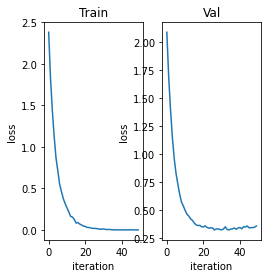

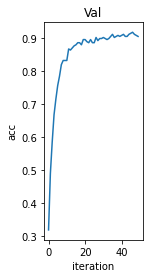

In [ ]:
from pickle import dump, load
import matplotlib.pyplot as plt
import numpy as np

modelName = "mobilenet_freezed_rmsprop_0.000001_dropout0.1_250"
absPath = "/content/drive/My Drive/TA/"

# train 968 vid
# val 316 vid
f = open(absPath+modelName+"/loss_train.bin", "rb")
trainLossesTemp = load(f)
f.close()
trainLosses = []
i = 0
l = len(trainLossesTemp)
while i<l:
    trainLosses.append(np.mean(trainLossesTemp[i:min(i+968, l-1)]))
    i+=968

f = open(absPath+modelName+"/loss_val.bin", "rb")
valLossesTemp = load(f)
f.close()
valLosses = []
i = 0
l = len(valLossesTemp)
while i<l:
    valLosses.append(np.mean(valLossesTemp[i:min(i+316, l-1)]))
    i+=316

f = open(absPath+modelName+"/accuracy_val.bin", "rb")
valAccTemp = load(f)
f.close()
valAcc = []
i = 0
l = len(valAccTemp)
while i<l:
    valAcc.append(np.sum(valAccTemp[i:min(i+316, l-1)])/min(316, l-i))
    if i>56*316: print(i/316, ",", np.sum(valAccTemp[i:min(i+316, l-1)])/min(316, l-i))
    i+=316

f = open(absPath+modelName+"/confusion_matrices_val.bin", "rb")
confusionMatrices = load(f)
f.close()

vl = np.argmin(valLosses)
va = np.argmax(valAcc)
print(vl, va)
print(valAcc[vl], valAcc[va])
print(len(valAcc))

fig = plt.figure()
plt.subplot(131)
plt.plot(trainLosses)
plt.ylabel("loss")
plt.xlabel("iteration")
plt.title("Train")

plt.subplot(132)
plt.plot(valLosses)
plt.ylabel("loss")
plt.xlabel("iteration")
plt.title("Val")
plt.show()

plt.subplot(133)
plt.plot(valAcc)
plt.ylabel("acc")
plt.xlabel("iteration")
plt.title("Val")
plt.show()

# print(confusionMatrices[-1])